Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

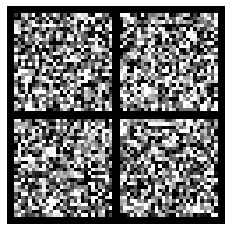

Sampling:  10%|▉         | 99/1000 [00:01<00:13, 67.49it/s]

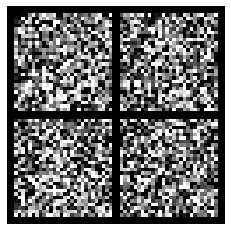

Sampling:  20%|█▉        | 199/1000 [00:03<00:11, 67.49it/s]

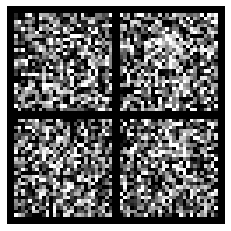

Sampling:  30%|███       | 300/1000 [00:04<00:10, 67.40it/s]

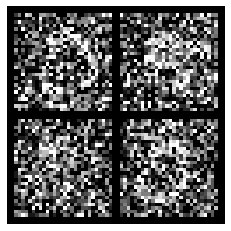

Sampling:  40%|███▉      | 399/1000 [00:06<00:08, 69.25it/s]

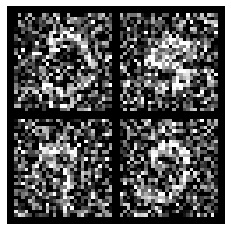

Sampling:  50%|████▉     | 499/1000 [00:07<00:07, 66.61it/s]

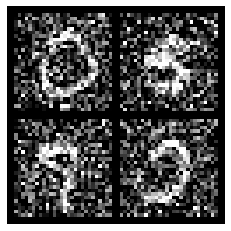

Sampling:  60%|█████▉    | 599/1000 [00:09<00:06, 66.57it/s]

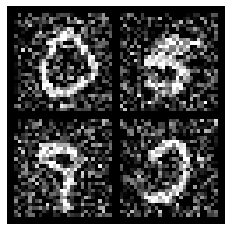

Sampling:  69%|██████▉   | 694/1000 [00:10<00:04, 66.51it/s]

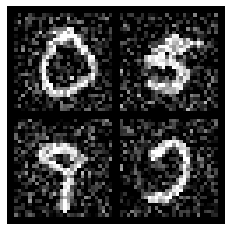

Sampling:  79%|███████▉  | 794/1000 [00:12<00:03, 66.06it/s]

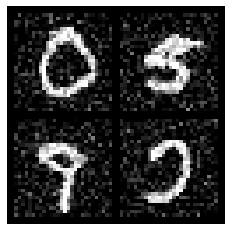

Sampling:  89%|████████▉ | 894/1000 [00:13<00:01, 66.60it/s]

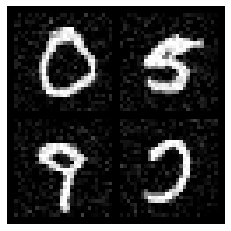

Sampling: 100%|█████████▉| 999/1000 [00:15<00:00, 67.17it/s]

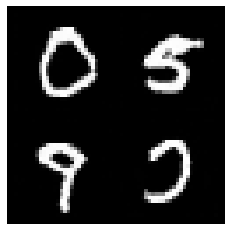

Sampling: 100%|██████████| 1000/1000 [00:15<00:00, 64.80it/s]


In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms 
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from model import MNISTDiffusion
from utils import ExponentialMovingAverage
import os
import math
import argparse

def create_mnist_dataloaders(batch_size,image_size=28,num_workers=4):
    
    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )
    test_dataset=MNIST(root="./mnist_data",\
                        train=False,\
                        download=True,\
                        transform=preprocess
                        )

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers),\
            DataLoader(test_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)






def main(args):
    device="cpu" if args.cpu else "cuda"
    train_dataloader,test_dataloader=create_mnist_dataloaders(batch_size=args.batch_size,image_size=28)
    model=MNISTDiffusion(timesteps=args.timesteps,
                image_size=28,
                in_channels=1,
                base_dim=args.model_base_dim,
                dim_mults=[2,4]).to(device)

    #torchvision ema setting
    #https://github.com/pytorch/vision/blob/main/references/classification/train.py#L317
    adjust = 1* args.batch_size * args.model_ema_steps / args.epochs
    alpha = 1.0 - args.model_ema_decay
    alpha = min(1.0, alpha * adjust)
    model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)

    optimizer=AdamW(model.parameters(),lr=args.lr)
    scheduler=OneCycleLR(optimizer,args.lr,total_steps=args.epochs*len(train_dataloader),pct_start=0.25,anneal_strategy='cos')
    loss_fn=nn.MSELoss(reduction='mean')

    #load checkpoint
    if args.ckpt:
        ckpt=torch.load(args.ckpt)
        model_ema.load_state_dict(ckpt["model_ema"])
        model.load_state_dict(ckpt["model"])

    global_steps=0
    model_ema.eval()
    samples=model_ema.module.sampling_process(args.n_samples,clipped_reverse_diffusion=not args.no_clip,device=device)



if __name__=="__main__":
    class Args:
        pass
    args = Args()
    args.lr = 0.001
    args.batch_size = 128
    args.epochs = 100
    args.ckpt = "results/steps_00011725.pt"
    args.n_samples = 36
    args.model_base_dim = 64
    args.timesteps = 1000
    args.model_ema_steps = 10
    args.model_ema_decay = 0.995
    args.log_freq = 10
    args.no_clip = False  # 是否禁用 clip
    args.cpu = False      # 是否强制使用 CPU
    main(args)